In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

DATA = Path("../data")
OUT  = Path("../output")
OUT.mkdir(exist_ok=True)


In [2]:
df = pd.read_csv(DATA / "flight_cleaned_va_all_years.csv")

df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

mask = np.isfinite(df["latitude"]) & np.isfinite(df["longitude"])
df = df[mask].copy()

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

print("Rows:", len(gdf))
print("Bounds (lon/lat):", gdf.total_bounds)


Rows: 2056
Bounds (lon/lat): [-83.0331    36.558914 -75.54      39.25669 ]


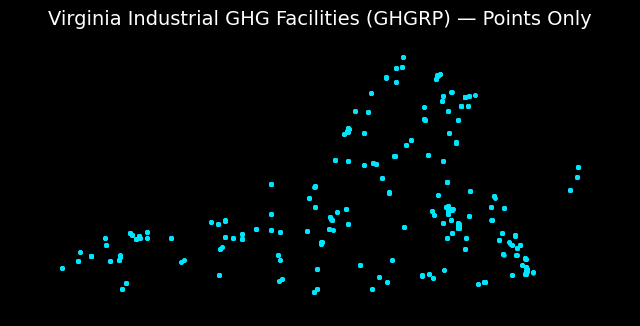

Saved: C:\Users\blake\va-ghg-dashboard\output\va_points_points_only.png


In [3]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    ax=ax,
    markersize=6,
    color="#00e6ff",
    alpha=0.75
)

# Set extent with padding so it looks like a "state view"
minx, miny, maxx, maxy = gdf.total_bounds
padx = (maxx - minx) * 0.10
pady = (maxy - miny) * 0.10

ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_axis_off()
fig.patch.set_facecolor("#000000")
ax.set_facecolor("#000000")

plt.title("Virginia Industrial GHG Facilities (GHGRP) — Points Only", color="white", fontsize=14)

fig.savefig(
    OUT / "va_points_points_only.png",
    dpi=300,
    bbox_inches="tight",
    facecolor=fig.get_facecolor()
)
plt.show()

print("Saved:", (OUT / "va_points_points_only.png").resolve())


In [4]:
cb_path = DATA / "boundaries" / "cb_2023_us_state_20m" / "cb_2023_us_state_20m.shp"
states_cb = gpd.read_file(cb_path)

va_cb = states_cb.loc[states_cb["STUSPS"] == "VA"].copy()

# Repair gently if needed
va_cb["geometry"] = va_cb["geometry"].buffer(0)

# Save as GeoJSON for future use (more portable)
va_geojson_path = DATA / "boundaries" / "va_boundary_20m.geojson"
va_cb.to_file(va_geojson_path, driver="GeoJSON")

print("Saved VA GeoJSON:", va_geojson_path)


Saved VA GeoJSON: ..\data\boundaries\va_boundary_20m.geojson


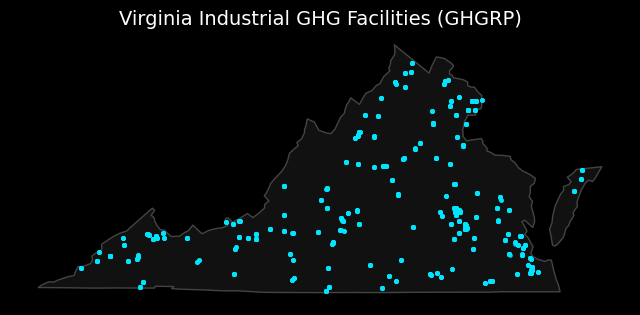

Saved: C:\Users\blake\va-ghg-dashboard\output\va_points_with_boundary.png


In [5]:
va_poly = gpd.read_file(DATA / "boundaries" / "va_boundary_20m.geojson")

fig, ax = plt.subplots(figsize=(8, 10))

va_poly.plot(ax=ax, color="#111111", edgecolor="#444444", linewidth=1)
gdf.plot(ax=ax, markersize=6, color="#00e6ff", alpha=0.75)

ax.set_axis_off()
fig.patch.set_facecolor("#000000")
ax.set_facecolor("#000000")

plt.title("Virginia Industrial GHG Facilities (GHGRP)", color="white", fontsize=14)

fig.savefig(
    OUT / "va_points_with_boundary.png",
    dpi=300,
    bbox_inches="tight",
    facecolor=fig.get_facecolor()
)
plt.show()

print("Saved:", (OUT / "va_points_with_boundary.png").resolve())


In [6]:
# Convert polygon and points into same CRS (keep in EPSG:4326 for simplicity)
va_geom = va_poly.geometry.iloc[0]

# "covers" includes boundary points
inside = gdf.geometry.apply(va_geom.covers)

valid_points = gdf[inside].copy()
outside_points = gdf[~inside].copy()

print("Valid:", len(valid_points), "Outside:", len(outside_points))


Valid: 2042 Outside: 14
